# **Setup**

In [1]:
import os
import sys
import glob
import copy
import random
import joblib
import time
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import torchvision

from skimage import io

from PIL import Image

from sklearn import preprocessing
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## !! TODO | Define & select your paths

In [3]:

path = f"/content/drive/MyDrive/DViP/" #local path of pulled repo
DIR_DATEN = "/content/drive/MyDrive/DViP/data/" #local path where the .zip files are stored


In [5]:
sys.path.append(path)
sys.path.append(path + "ImageClassification")

# DIR_DATEN_01 = os.path.join(DIR_DATEN, "01_Daten")
# DIR_WAFER_IMAGES = os.path.join(DIR_DATEN, "WaferImages")
DIR_RESULTS = os.path.join(path,"results")
DIR_MODELS = os.path.join(path,"models")
subdir = str(input("Model Version as String (for instance 1a)?:"))
SUBDIR_RESULTS = os.path.join(DIR_RESULTS, subdir)

SUBDIR_MODELS = os.path.join(DIR_MODELS, subdir)

Model Version as String (for instance 1a)?:5f


## Script Imports

In [56]:
from early_stopper import EarlyStopping
from utils import seed_libraries, load_image, reset_weights
from DVP_datasets import DVPDataset, WaferDataset, WaferBaseDataset
from DVP_models import BaseNet,BaseNet8, BaseNet8plus, IncNet, ResiNet, RegNet, OctaNet
from config import config

In [7]:
SEED=42
seed_libraries(SEED=SEED)


# set computation device
runtime = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Computation device: {runtime}")

Computation device: cuda


# **Load** Data

In [16]:
# 3 classes
# ['good', 'low_level', 'circle'] # selecting easiest visually recognisable classes
#
# # 5 classes
# ['good', 'low_level', 'circle', 'crack', 'displaced'] # selecting bounding boxes classes
#
# # 8 classs
# ['good', 'low_level', 'circle', 'crack', 'displaced', 'scratch', 'splinter', 'waferonpin']

In [17]:
data_file_name = 'WaferImages_en_8'
 

PATH_DATA = f'{DIR_DATEN}/{data_file_name}.zip'
print('Path: '+ str(PATH_DATA))

!unzip $PATH_DATA

image_dataset = torchvision.datasets.ImageFolder(f'/content/{data_file_name}')

Path: /content/drive/MyDrive/DViP/data//WaferImages_en_8.zip
Archive:  /content/drive/MyDrive/DViP/data//WaferImages_en_8.zip
   creating: WaferImages_en_8/
   creating: WaferImages_en_8/circle/
  inflating: WaferImages_en_8/circle/001846865.tif  
  inflating: WaferImages_en_8/circle/001846869.tif  
  inflating: WaferImages_en_8/circle/001850805.tif  
  inflating: WaferImages_en_8/circle/001850893.tif  
  inflating: WaferImages_en_8/circle/001851068.tif  
  inflating: WaferImages_en_8/circle/001851079.tif  
  inflating: WaferImages_en_8/circle/001851088.tif  
  inflating: WaferImages_en_8/circle/001851139.tif  
  inflating: WaferImages_en_8/circle/001852513.tif  
  inflating: WaferImages_en_8/circle/001852550.tif  
  inflating: WaferImages_en_8/circle/001853657.tif  
  inflating: WaferImages_en_8/circle/001854224.tif  
  inflating: WaferImages_en_8/circle/001856142.tif  
  inflating: WaferImages_en_8/circle/001856991.tif  
  inflating: WaferImages_en_8/circle/001861270.tif  
  inflatin

# **Split** and  **Preprocess** Data

In [18]:
# todo: check

shuffle = True
random_state = 42

# Prepare Dataset into Train and Val and and Test (60:20:20)

dataset_size = len(image_dataset)
indices = list(range(dataset_size))

train_val_indices, test_indices = train_test_split(indices,
                                                    stratify=[image_dataset.targets[i] for i in indices],
                                                    test_size=0.20,
                                                    shuffle=shuffle,
                                                   random_state=random_state,
                                                   )

train_indices, val_indices = train_test_split(train_val_indices,
                                            stratify=[image_dataset.targets[i] for i in train_val_indices],
                                            test_size=0.25,
                                            shuffle=shuffle,
                                            random_state=random_state,
                                            )

train_subset = Subset(image_dataset, train_indices)
val_subset = Subset(image_dataset, val_indices)
test_subset = Subset(image_dataset, test_indices)


In [19]:
print(len(train_subset))
print(len(val_subset))
print(len(test_subset))

2604
868
869


In [20]:
calculated_mean = 0.664504
calculated_std = 0.286775

data_transforms = {
    'train': {
        'VGG16': transforms.Compose([
              transforms.Resize(244),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              #transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # duplicate channel as Resnet18 based on RGB
              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        'VicNet': transforms.Compose([
              transforms.Resize(256),
              transforms.ToTensor(),
              #transforms.Grayscale(num_output_channels=1),
        ]),
        'MaxNet': transforms.Compose([
              transforms.Resize(256),
              transforms.ToTensor(),
              #transforms.Grayscale(num_output_channels=1),
        ]),
        ('BaseNet'): transforms.Compose([
              transforms.Resize(256),
              transforms.ToTensor(),
              transforms.Grayscale(num_output_channels=1),

        ]),
        ('BaseNet_V1'): transforms.Compose([
              transforms.Resize(256),
              transforms.ToTensor(),
              # Data augmentation
              transforms.RandomHorizontalFlip(p=0.5),
        ]),
        ('Explore_old'): transforms.Compose([
              transforms.Resize(256),
              transforms.ToTensor(),
              transforms.Normalize(mean=[calculated_mean], std=[calculated_std]),
              transforms.RandomHorizontalFlip(p=0.3),
              transforms.RandomVerticalFlip(p=0.3),
              transforms.RandomApply([transforms.RandomRotation(degrees=(90, 90))],p=0.3),
              transforms.RandomApply([transforms.RandomRotation(degrees=(180, 180))],p=0.3),
              transforms.RandomApply([transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 1.5))],p=0.3),
        ]),
        ('Explore'): transforms.Compose([
              transforms.Resize(256),
              transforms.ToTensor(),
              transforms.Resize((256,256)),
              #transforms.CenterCrop(235)
              transforms.RandomInvert(p=1)
        ]),
    },
    'test_or_val': { # No Data Augmentation after Training!
        'VGG16': transforms.Compose([
              transforms.Resize(244),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              #transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # duplicate channel as Resnet18 based on RGB
              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        'VicNet': transforms.Compose([
              transforms.Resize(256),
              transforms.ToTensor(),
              #transforms.Grayscale(num_output_channels=1),
        ]),
        'MaxNet': transforms.Compose([
              transforms.Resize(256),
              transforms.ToTensor(),
              #transforms.Grayscale(num_output_channels=1),
        ]),
        'BaseNet': transforms.Compose([
              transforms.Resize(256),
              transforms.ToTensor(),
              transforms.Grayscale(num_output_channels=1),
        ]),
        ('Explore'): transforms.Compose([
              transforms.Resize(256),
              transforms.ToTensor(),
        ]),
    }

}

# now put it in DataLoaders
train_dataset = DVPDataset(train_subset, data_transforms['train']['Explore'])
val_dataset = DVPDataset(val_subset, data_transforms['test_or_val']['Explore'])
test_dataset = DVPDataset(test_subset, data_transforms['test_or_val']['Explore'])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=config['batch_size'])
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=config['batch_size'])



In [21]:
def show_batch(dataloader,size = 16):

    inputs, classes = next(iter(dataloader))
    inputs = inputs.squeeze(1)
    inputs = inputs.numpy()
    w,h = size, size
    fig=plt.figure(figsize=(w, h))
    columns = 4
    rows = 1
    ax=[]
    for i in range(1, columns*rows +1):
        ax.append(fig.add_subplot(rows, columns, i))
        #ax[-1].set_title('Class: '+str(classes[i].item()))
        ax[-1].set_title('Class: '+str(image_dataset.classes[classes[i].item()]))
        plt.imshow((inputs[i]).transpose(1, 2, 0), cmap='gray')
    plt.subplots_adjust(hspace=-0.3, wspace=0.4)
    plt.show()

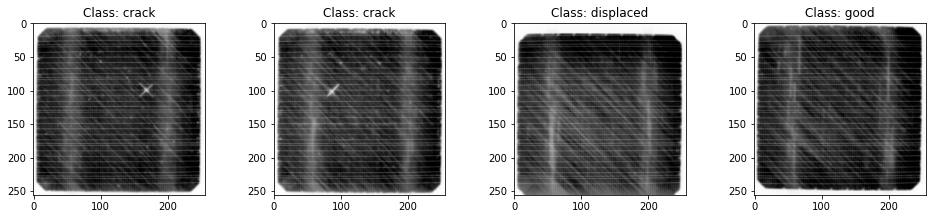

In [22]:
show_batch(train_dataloader)

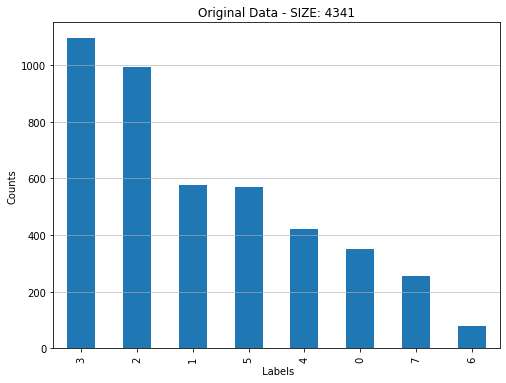

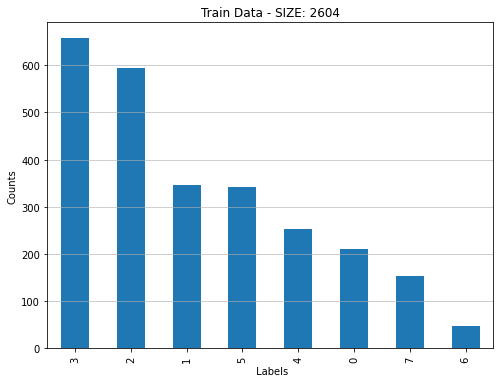

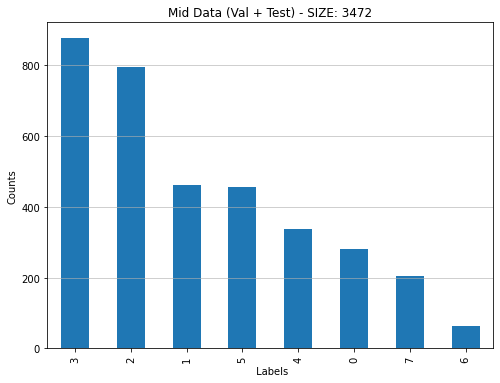

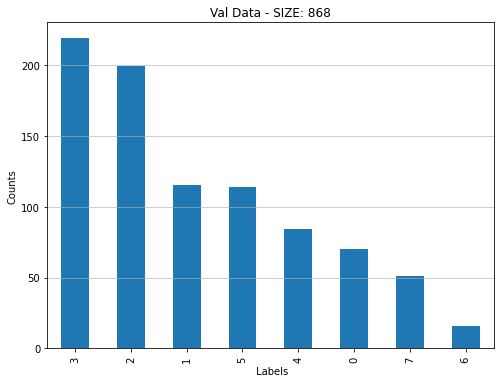

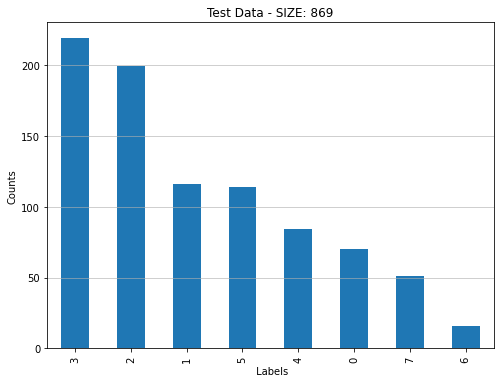

In [23]:
# todo: use image_dataset instead of x and y

#y_lb = [inverse_mapping[k] for k in y]
plt.figure(figsize=(8,6))
pd.Series(np.array(image_dataset.targets)).value_counts().plot(kind='bar')
plt.title('Original Data' + ' - SIZE: ' + str(len(np.array(image_dataset.targets))))
plt.xlabel(' Labels')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)

# y_train_lb = [inverse_mapping[k] for k in y_train]
plt.figure(figsize=(8,6))
pd.Series(np.array(image_dataset.targets)[train_indices]).value_counts().plot(kind='bar')
plt.title('Train Data' + ' - SIZE: ' + str(len(np.array(image_dataset.targets)[train_indices])))
plt.xlabel(' Labels')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)

# y_train_val_lb = [inverse_mapping[k] for k in y_train_val]
plt.figure(figsize=(8,6))
pd.Series(np.array(image_dataset.targets)[train_val_indices]).value_counts().plot(kind='bar')
plt.title('Mid Data (Val + Test)' + ' - SIZE: ' + str(len(np.array(image_dataset.targets)[train_val_indices])))
plt.xlabel(' Labels')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)

# y_val_lb = [inverse_mapping[k] for k in y_val]
plt.figure(figsize=(8,6))
pd.Series(np.array(image_dataset.targets)[val_indices]).value_counts().plot(kind='bar')
plt.title('Val Data' + ' - SIZE: ' + str(len(np.array(image_dataset.targets)[val_indices])))
plt.xlabel(' Labels')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)

# y_test_lb = [inverse_mapping[k] for k in y_test]
plt.figure(figsize=(8,6))
pd.Series(np.array(image_dataset.targets)[test_indices]).value_counts().plot(kind='bar')
plt.title('Test Data' + ' - SIZE: ' + str(len(np.array(image_dataset.targets)[test_indices])))
plt.xlabel(' Labels')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)

# Models

**BaseNet**

In [24]:
n_classes = len(image_dataset.classes)

basenet = BaseNet(n_classes)
basenet.name = "BaseNet"

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


**BaseNet8**

In [57]:
basenet8 = BaseNet8(n_classes)
basenet8.name = "BaseNet8"

**BaseNet8**

In [ ]:
basenet8plus = BaseNet8plus(n_classes)
basenet8plus.name = "BaseNet8plus"

**VicNet**

In [49]:
resinet = ResiNet(n_classes)
resinet.name = "ResiNet"

**MaxNet**

In [50]:
incnet = IncNet(n_classes)
incnet.name = "IncNet"

**OctaNet**

In [27]:
# octanet = OctaNet(n_classes)
# octanet.name = "OctaNet"

**ResNet**

In [28]:
# resnet18 = models.resnet18(pretrained=True)
# for param in resnet18.parameters():
    # todo: maybe model centric not Freezing layers
#   param.requires_grad=False # freezes the layers to only fine-tune the last one
# resnet18.name = "ResNet18"

**VGG16**

In [29]:
vgg16 = models.vgg16(pretrained=True)
for param in vgg16.features.parameters():
  param.requires_grad=False # freezes the layers to only fine-tune the last one

vgg16.name = "VGG16"

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

# Model Selection

In [51]:
list_transfer_model = ['ResNet18', 'VGG16']

# CHANGE AS NEEDED:
# basenet, basenet8, vicnet, octanet
# vgg16
net = basenet8plus

In [63]:
#from torchsummary import summary
#summary(basenet8.to(torch.device('cuda')), (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 256, 256]              40
              ReLU-2          [-1, 4, 256, 256]               0
         MaxPool2d-3          [-1, 4, 128, 128]               0
            Conv2d-4          [-1, 8, 128, 128]             296
              ReLU-5          [-1, 8, 128, 128]               0
         MaxPool2d-6            [-1, 8, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]           1,168
              ReLU-8           [-1, 16, 64, 64]               0
         MaxPool2d-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 32, 32, 32]           4,640
             ReLU-11           [-1, 32, 32, 32]               0
        MaxPool2d-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          18,496
             ReLU-14           [-1, 64,

# Training

To measuse inference time: https://towardsdatascience.com/the-correct-way-to-measure-inference-time-of-deep-neural-networks-304a54e5187f

In [ ]:
debug = True

early_stopping_patience = 10
epochs = config['epochs']
min_val_loss = np.Inf

# initialize the early_stopping object
early_stopping = EarlyStopping(patience=early_stopping_patience, verbose=True)

# Init the neural network
if net.name == 'VGG16':
  # Add Classifier Layer to backbone transfer model
  # Newly created modules have require_grad=True by default
  num_features = net.classifier[6].in_features
  features = list(net.classifier.children())[:-1] # Remove last layer
  features.extend([nn.Linear(num_features, n_classes)]) # Add our layer with 4 outputs
  net.classifier = nn.Sequential(*features) # Replace the model classifier
elif net.name == 'ResNet18':
  net.fc = nn.Linear(512, n_classes)
else:
  net.apply(reset_weights)

if debug:
  print(net)

# Model to Cuda
net = net.to(runtime)

print('\n')

# Define the optimizer
if config['optimizer']=='sgd':
  optimizer = torch.optim.SGD(net.parameters(), lr=config['learning_rate'], momentum=0.9)
elif config['optimizer']=='adam':
  # Octanet Report: lr=0.001, weight_decay = 0.0001
  optimizer = torch.optim.Adam(net.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
loss_fct = nn.CrossEntropyLoss()
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [50, 100, 150], gamma=0.1)
# FOR 2a - 2c
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [25,45,50,55,58,60,62,64,66,68,70,72,74], gamma=0.1)

train_losses = []
val_losses = []
train_acc = []
val_acc = []
acc_val = 0
acc_train = 0
batch_ct = 0
example_ct = 0


starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
timings=[]
frames = []

for epoch in range(epochs):
  # This command tells the neural network that it should be in training-mode now.
  # This call is important as some functions in neural networks (e.g., dropout) should 
  # only be applied when training
  net.train()

  total=0
  correct=0

  epoch_train_loss = 0.
  # Iterate over the dataset in chunks of size 32 (the batches)
  for i, data in enumerate(train_dataloader):
    X_batch, y_batch = data[0].to(runtime), data[1].to(runtime)

    y_pred = net(X_batch)

    loss = loss_fct(y_pred, y_batch)

    example_ct += len(data)

    epoch_train_loss += loss.item() * X_batch.size(0)
    _,pred = torch.max(y_pred, dim=1)

    #add the count of correct prediction of the batch to a correct prediction list
    correct += torch.sum(pred==y_batch).item()
    #add the count of all predictions of the batch to a total prediction list
    total += y_batch.size(0)
    #calculate accuracy of all predicted samples so far
    acc_train = 100 * correct/total

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  epoch_train_loss = epoch_train_loss / len(train_dataloader.sampler)
  train_losses.append(epoch_train_loss)
  train_acc.append(acc_train)
  #scheduler.step()

  net.eval()

  total_t=0
  correct_t=0

  # Init or reset the prediction and label lists(tensors) of a epoch
  predlist=torch.zeros(0,dtype=torch.long, device=runtime)
  lbllist=torch.zeros(0,dtype=torch.long, device=runtime)


  epoch_val_loss = 0. #reset epoch loss from validation

  # This command tells the neural network that it should be in evaluation mode now.
  # This call turns of special functions for training, such as dropout. 
  
  with torch.no_grad():
    for X_batch_val, y_batch_val in (val_dataloader):
      #load batch of validation data
      X_batch_val, y_batch_val = X_batch_val.to(runtime), y_batch_val.to(runtime)

      #predict batch
      starter.record()
      y_pred_val = net(X_batch_val)
      ender.record()

      if runtime == torch.device('cuda'):
          torch.cuda.synchronize() 

      laps_time = starter.elapsed_time(ender)
      
      timings.append(laps_time / X_batch_val.size(0))
      frames.append(X_batch_val.size(0) / laps_time)

      
      loss_val = loss_fct(y_pred_val.squeeze(), y_batch_val)
      # append loss of batch to epoch loss
      epoch_val_loss += loss_val.item() * X_batch_val.size(0)
                                            
      _,pred_t = torch.max(y_pred_val, dim=1)

      #add the count of correct prediction of the batch to a correct prediction list
      correct_t += torch.sum(pred_t==y_batch_val).item()
      #add the count of all predictions of the batch to a total prediction list
      total_t += y_batch_val.size(0)
      #calculate accuracy of all predicted samples so far
      acc_val = 100 * correct_t/total_t

      # Concatenate the prediction of a batch to list of all prediction of a epoch
      predlist=torch.cat([predlist,pred_t.view(-1).to(runtime)])
      lbllist=torch.cat([lbllist,y_batch_val.view(-1).to(runtime)])

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model

    epoch_val_loss = epoch_val_loss / len(val_dataloader.sampler)
    val_losses.append(epoch_val_loss)
    val_acc.append(acc_val)

    print('Avg execution time (ms): {:.3f}'.format(np.mean(timings)))
    print('Avg frames per seconds (fps): {:.3f}'.format(np.mean(frames)))
    print('Epoch: {} ->  Train loss: {} Val loss: {} Train Accuracy: {} Val Accuracy: {}'.format(epoch, epoch_train_loss, epoch_val_loss, acc_train, acc_val))


  early_stopping(epoch_val_loss, net)
  
  if early_stopping.early_stop:
    print("----- EARLY STOPPING -----")
    break

# load model at best val loss
net.load_state_dict(torch.load("checkpoint.pt"))

y_true = lbllist.cpu().numpy()
y_pred = predlist.cpu().numpy()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Calling DataFrame constructor after zipping
# both lists, with columns specified
df_training = pd.DataFrame(list(zip(train_losses, val_losses,train_acc, val_acc, timings, frames)), columns =['Train_Loss', 'Val_Loss','Train_Acc', 'Val_Acc', 'Timings', 'Frames'])
TIME = datetime.datetime.now().strftime("%d-%m-%Y_%H:%M:%S") 
FILE_NAME = net.name + '_' + 'TRAIN' + '_' + TIME + ".csv"
if not os.path.exists(DIR_RESULTS):
    os.makedirs(DIR_RESULTS)
if not os.path.exists(SUBDIR_RESULTS):
    os.makedirs(SUBDIR_RESULTS)
df_training.to_csv(os.path.join(SUBDIR_RESULTS, FILE_NAME))

# Evaluation on Test Data

In [ ]:
net.eval()

total_tt=0
correct_tt=0

# Init or reset the prediction and label lists(tensors) of a epoch
predlist_tt=torch.zeros(0,dtype=torch.long, device=runtime)
lbllist_tt=torch.zeros(0,dtype=torch.long, device=runtime)


epoch_val_loss = 0. #reset epoch loss from validation

# This command tells the neural network that it should be in evaluation mode now.
# This call turns of special functions for training, such as dropout. 

with torch.no_grad():
  for X_batch_val, y_batch_val in (test_dataloader):
    #load batch of validation data
    X_batch_val, y_batch_val = X_batch_val.to(runtime), y_batch_val.to(runtime)

    #predict batch
    starter.record()
    y_pred_test = net(X_batch_val)
    ender.record()

    if runtime == torch.device('cuda'):
        torch.cuda.synchronize() 
                                          
    _,pred_tt = torch.max(y_pred_test, dim=1)

    #add the count of correct prediction of the batch to a correct prediction list
    correct_tt += torch.sum(pred_tt==y_batch_val).item()
    #add the count of all predictions of the batch to a total prediction list
    total_tt += y_batch_val.size(0)
    #calculate accuracy of all predicted samples so far
    acc_val = 100 * correct_tt/total_tt

    # Concatenate the prediction of a batch to list of all prediction of a epoch
    predlist_tt=torch.cat([predlist_tt,pred_tt.view(-1).to(runtime)])
    lbllist_tt=torch.cat([lbllist_tt,y_batch_val.view(-1).to(runtime)])


y_true = lbllist_tt.cpu().numpy()
y_pred = predlist_tt.cpu().numpy()


              precision    recall  f1-score   support

      circle      1.000     0.886     0.939        70
       crack      0.957     0.957     0.957       116
   displaced      0.980     0.970     0.975       199
        good      0.952     1.000     0.976       219
   low_level      1.000     0.988     0.994        84

    accuracy                          0.971       688
   macro avg      0.978     0.960     0.968       688
weighted avg      0.972     0.971     0.971       688

Overall accuracy: 97.09302325581395




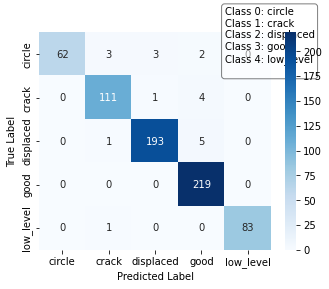

In [ ]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(7,4)) #tight_layout=True
conf_mat=confusion_matrix(y_true, y_pred)
ticks_label=list(classification_report(y_true, y_pred, output_dict=True, target_names=image_dataset.classes).keys())[:-3]
sns.heatmap(conf_mat, annot=True, fmt='.3g',cmap='Blues', xticklabels=ticks_label, yticklabels=ticks_label)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

legend = ""
for i, class_name in enumerate(image_dataset.classes):
  legend += f"Class {i}: {class_name}\n"

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

ax.text(4.0, 0.95, legend, bbox=props)
plt.subplots_adjust(right=0.7)

FILE_NAME = net.name + '_' + 'HEATMAP_CONFUSION_MATRIX' + "_with_legend" + ".png"
plt.savefig(os.path.join(SUBDIR_RESULTS, FILE_NAME))
FILE_NAME = net.name + '_' + 'HEATMAP_CONFUSION_MATRIX' + "_with_legend" +  ".pdf"
plt.savefig(os.path.join(SUBDIR_RESULTS, FILE_NAME))
FILE_NAME = net.name + '_' + 'HEATMAP_CONFUSION_MATRIX' + "_with_legend" +  ".jpg"
plt.savefig(os.path.join(SUBDIR_RESULTS, FILE_NAME))
# plt.show()
# print('\n')

confusion_matrix_df = pd.DataFrame(conf_mat, index=[f"predicted_{l}" for l in image_dataset.classes], columns=[f"true_{l}" for l in image_dataset.classes])

FILE_NAME = net.name + '_' + 'CONFUSION_MATRIX' + ".csv"
confusion_matrix_df.to_csv(os.path.join(SUBDIR_RESULTS, FILE_NAME), index=True)



# Precision, Recall, F1-score
class_report_print = classification_report(y_true, y_pred, digits=3, target_names=image_dataset.classes)
print(class_report_print)
class_report_dict = classification_report(y_true, y_pred, target_names=image_dataset.classes, output_dict=True)

# Per-class accuracy
# class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
overall_accuracy = 100 * sum(conf_mat.diagonal()) / len(predlist)
# print(f'Per-class accuracy: {class_accuracy}') # equals recall
print(f'Overall accuracy: {overall_accuracy}')
print('\n')

In [ ]:
# Calling DataFrame constructor after zipping
# both lists, with columns specified
df_report = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True, target_names=image_dataset.classes)).transpose()
TIME = datetime.datetime.now().strftime("%d-%m-%Y_%H:%M:%S")
FILE_NAME = net.name + '_' + 'TEST' + '_' + TIME + ".csv"

df_report.to_csv(os.path.join(SUBDIR_RESULTS, FILE_NAME))

## Plots

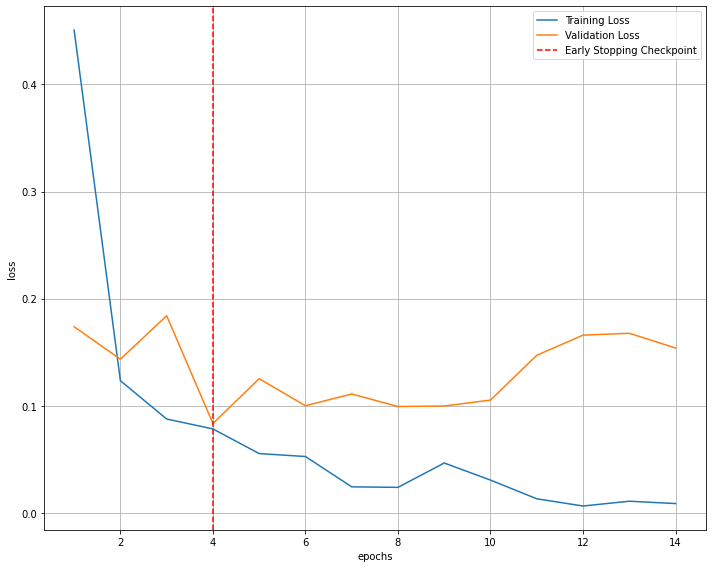

In [ ]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_losses)+1),train_losses, label='Training Loss')
plt.plot(range(1,len(val_losses)+1),val_losses,label='Validation Loss')

# find position of lowest validation loss
minpos = val_losses.index(min(val_losses))+1 
plt.axvline(minpos, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
#plt.ylim(0, 0.5) # consistent scale
#plt.xlim(0, len(train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()

FILE_NAME = net.name + "train_val_loss" + ".pdf"

fig.savefig(os.path.join(SUBDIR_RESULTS, FILE_NAME), bbox_inches='tight')
#fig.savefig('loss_plot.png', bbox_inches='tight')

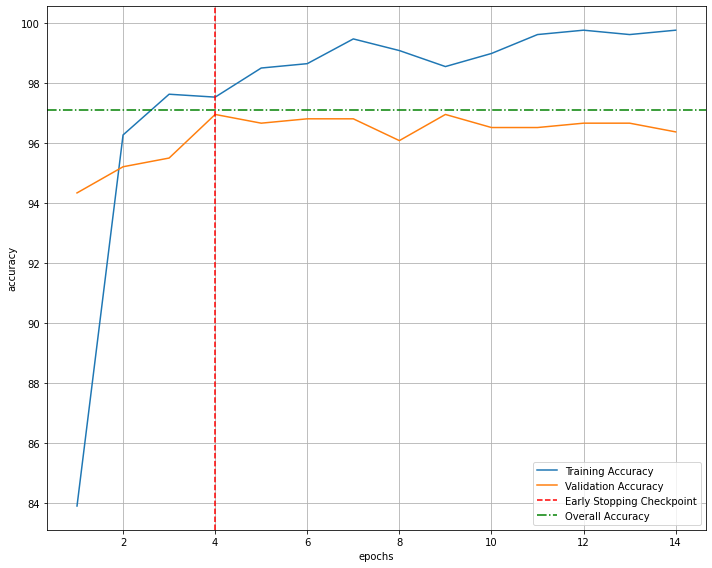

In [ ]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_acc)+1),train_acc, label='Training Accuracy')
plt.plot(range(1,len(val_acc)+1),val_acc,label='Validation Accuracy')

# find position of lowest validation loss
minpos = val_losses.index(min(val_losses))+1 
plt.axvline(minpos, linestyle='--', color='r',label='Early Stopping Checkpoint')

# draw overall accuracy
overall_acc = overall_accuracy = 100 * sum(conf_mat.diagonal()) / len(predlist)
plt.axhline(overall_acc, linestyle='-.', color='g', label='Overall Accuracy')

plt.xlabel('epochs')
plt.ylabel('accuracy')
#plt.ylim(0, 0.5) # consistent scale
#plt.xlim(0, len(train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()

FILE_NAME = net.name + "train_val_accuracy" + ".pdf"

fig.savefig(os.path.join(SUBDIR_RESULTS, FILE_NAME), bbox_inches='tight')
#fig.savefig('accuracies_plot.png', bbox_inches='tight')

# Save Model

In [ ]:
if not os.path.exists(SUBDIR_MODELS):
    os.makedirs(SUBDIR_MODELS)
torch.save(net.state_dict(), os.path.join(SUBDIR_MODELS, net.name+'_'+str(n_classes)+'.pth'))